In [1]:
from scipy import stats
import os
import sys
sys.path.append('..\..')
import seaborn as sns
from utils.tracking_analysis.tracking_plotting import *
from set_global_params import raw_tracking_path, processed_data_path, figure_directory
from utils.reaction_time_utils import get_bpod_trial_nums_per_session
from utils.post_processing_utils import get_all_experimental_records
from utils.post_processing_utils import remove_exps_after_manipulations, remove_unsuitable_recordings, remove_manipulation_days
from utils.plotting_visuals import makes_plots_pretty
from utils.stats import cohen_d_one_sample

In [2]:
def get_session_with_10000th_trial(mouse, experiments):
    dates = experiments[experiments['mouse_id']==mouse]['date'].unique()
    session_starts = get_bpod_trial_nums_per_session(mouse, dates)
    if session_starts[-1] >= 10000:
        last_session_idx = np.where(np.asarray(session_starts) >=10000)[0][0]
    else:
        last_session_idx = -1
    last_session_date = dates[last_session_idx]
    return(last_session_date)

In [3]:
mouse = 'SNL_photo17' #example_mouse_used_in_paper
recording_site = 'tail'
all_experiments = get_all_experimental_records()
all_experiments = remove_exps_after_manipulations(all_experiments, [mouse])
all_experiments = remove_manipulation_days(all_experiments)
all_experiments = remove_unsuitable_recordings(all_experiments)
experiments_to_process = all_experiments[
    (all_experiments['mouse_id'] == mouse) & (all_experiments['recording_site'] == recording_site)]
last_session = get_session_with_10000th_trial(mouse, experiments_to_process)

In [4]:
dates = experiments_to_process['date'].values
last_session_ind = int(np.where(dates == last_session)[0])
for i, date in enumerate(dates[0: last_session_ind + 1]):
    save_out_folder = os.path.join(raw_tracking_path, mouse, date)
    movement_param_file = os.path.join(save_out_folder, 'APE_tracking{}_{}.pkl'.format(mouse, date))
    if os.path.isfile(movement_param_file):
        session_data = pd.read_pickle(movement_param_file)
        session_data['date'] = date
        session_data.mouse = mouse
        print(date, session_data.shape)
        if i == 0:
            all_session_data = session_data
        else:
            all_session_data = pd.concat([all_session_data, session_data])
    else:
        print('{} not found'.format(date))
all_session_data = all_session_data.reset_index(drop=True)

20200204 (145, 50)
20200206 (208, 50)
20200208 (439, 50)
20200210 (246, 50)
20200212 (222, 50)
20200214 (265, 50)
20200218 (358, 50)
20200221 (289, 50)
20200224 (238, 50)
20200226 (267, 50)
20200228 (251, 50)
20200303 (298, 50)
20200305 (279, 50)
20200307 (304, 50)
20200310 (278, 50)


In [5]:
all_session_data['abs fitted max cumsum ang vel'] = all_session_data['fitted max cumsum ang vel'].abs()

In [6]:
contra_data = all_session_data[all_session_data.side == 'contra']

In [7]:
def filter_trials_around_reaction_time(side_data, window_around_mean=0.2):
    data = side_data.reset_index(drop=True)
    reaction_times = data['reaction times'].values
    median_reaction_time = np.nanmedian(reaction_times)
    valid_trials = np.where(
            np.logical_and(np.greater_equal(reaction_times, median_reaction_time - window_around_mean),
                           np.less_equal(reaction_times, median_reaction_time + window_around_mean)))
    valid_data = data.loc[valid_trials]
    return valid_data

In [8]:
valid_contra_data = filter_trials_around_reaction_time(contra_data)

In [9]:
ipsi_data = all_session_data[all_session_data.side == 'ipsi']

# correlate speed and turn angle with APE

0.07775178122494716


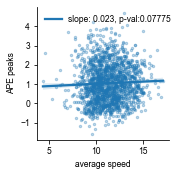

In [10]:
font = {'size': 8.5, 'family':'sans-serif', 'sans-serif':['Arial']}

matplotlib.rc('font', **font)
matplotlib.rcParams['pdf.fonttype'] = 42
fig, ax = plt.subplots(1,1, figsize=[2.5,2.5])

slope, intercept, r_value, p_value, std_err = stats.linregress(valid_contra_data['average speed'],valid_contra_data['APE peaks'])

sns.regplot(ax=ax, data=valid_contra_data, x='average speed', y='APE peaks', line_kws={'label':"slope: {0:.3f}, p-val:{1:.5f}".format(slope,p_value)},
                scatter_kws={'s':6, 'alpha':0.3})
ax.legend(frameon=False, loc='upper left')
print(p_value)
makes_plots_pretty(ax)
plt.tight_layout()


6.26321050884039e-06


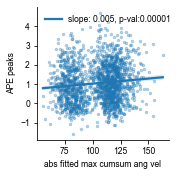

In [11]:
font = {'size': 8.5, 'family':'sans-serif', 'sans-serif':['Arial']}

matplotlib.rc('font', **font)
matplotlib.rcParams['pdf.fonttype'] = 42
fig, ax = plt.subplots(1,1, figsize=[2.5,2.5])

data = valid_contra_data.dropna()
slope, intercept, r_value, p_value, std_err = stats.linregress(data['abs fitted max cumsum ang vel'],data['APE peaks'])
sns.regplot(ax=ax, data=data, x='abs fitted max cumsum ang vel', y='APE peaks', line_kws={'label':"slope: {0:.3f}, p-val:{1:.5f}".format(slope,p_value)},
            scatter_kws={'s':6, 'alpha':0.3})
ax.legend(frameon=False, loc='upper left')
print(p_value)
makes_plots_pretty(ax)
plt.tight_layout()


6.26321050884039e-06


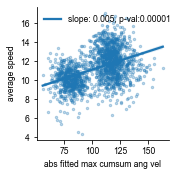

In [12]:
font = {'size': 8.5, 'family':'sans-serif', 'sans-serif':['Arial']}

matplotlib.rc('font', **font)
matplotlib.rcParams['pdf.fonttype'] = 42
fig, ax = plt.subplots(1,1, figsize=[2.5,2.5])

data = valid_contra_data.dropna()
slope, intercept, r_value, p_value, std_err = stats.linregress(data['abs fitted max cumsum ang vel'],data['APE peaks'])
sns.regplot(ax=ax, data=data, x='abs fitted max cumsum ang vel', y='average speed', line_kws={'label':"slope: {0:.3f}, p-val:{1:.5f}".format(slope,p_value)},
            scatter_kws={'s':6, 'alpha':0.3})
ax.legend(frameon=False, loc='upper left')
print(p_value)
makes_plots_pretty(ax)
plt.tight_layout()


## regression with effects of trial number, speed and turn angle on APE size

In [13]:
import statsmodels.api as sm

In [14]:
df = valid_contra_data.sort_values(by='actual trial numbers')
df = df.replace({'stay': 0, 'swiatch': 1, 'ipsi': 0, 'contra': 1})
key = 'average speed'
key2 = 'abs fitted max cumsum ang vel'
key1 = 'stay or switch'
mouse_data = df.dropna(axis=0) 

Y = mouse_data['APE peaks'].reset_index(drop=True)
X = mouse_data[[key, key2]].reset_index(drop=True)
#X = pd.concat([np.abs(mouse_data[key]), mouse_data['contra sensory evidence']], axis=1)
X = sm.add_constant(X).reset_index(drop=True)
model = sm.OLS(Y, X)
result = model.fit()
movement_model_rsq = result.rsquared
print(movement_model_rsq)
movement_model_prediction = model.predict(result.params)
movement_model_diff_data = Y - movement_model_prediction 

0.011663165244966023


C:\Users\francescag\AppData\Local\Continuum\miniconda3\envs\py38\lib\site-packages\pandas\core\array_algos\replace.py:85: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  op = lambda x: operator.eq(x, b)


In [15]:
df = valid_contra_data.sort_values(by='actual trial numbers')
df = df.replace({'stay': 0, 'swiatch': 1, 'ipsi': 0, 'contra': 1})
mouse_data = df.dropna(axis=0) 

data = mouse_data
valid_trial_numbers = data['actual trial numbers'].values
APEs = data['APE peaks'].values
outcomes = data['outcome'].values
turn_angle = data['abs fitted max cumsum ang vel'].values
speed = data['average speed'].values
window_size = 40
rolling_mean_x = []
rolling_mean_APEs = []
rolling_mean_speed = []
rolling_mean_turn_angle= []
rolling_mean_performance = []
num_bins = int(data.shape[0]/window_size)
for window_num in range(num_bins):
    rolling_mean_x.append(np.nanmean(valid_trial_numbers[window_num * window_size: (window_num + 1) * window_size]))
    rolling_mean_turn_angle.append(np.nanmean(turn_angle[window_num * window_size: (window_num + 1) * window_size]))
    rolling_mean_speed.append(np.nanmean(speed[window_num * window_size: (window_num + 1) * window_size]))
    rolling_mean_APEs.append(np.nanmean(APEs[window_num * window_size: (window_num + 1) * window_size]))
    rolling_mean_performance.append(np.nanmean(outcomes[window_num * window_size: (window_num + 1) * window_size]))

C:\Users\francescag\AppData\Local\Continuum\miniconda3\envs\py38\lib\site-packages\pandas\core\array_algos\replace.py:85: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  op = lambda x: operator.eq(x, b)


In [16]:
df = valid_contra_data.sort_values(by='actual trial numbers')
df = df.replace({'stay': 0, 'swiatch': 1, 'ipsi': 0, 'contra': 1})
mouse_data = df.dropna(axis=0) 

data = mouse_data
valid_trial_numbers = data['actual trial numbers'].values
APEs = data['APE peaks'].values
outcomes = data['outcome'].values
window_size = 40
rolling_mean_x = []
rolling_mean_APEs = []
rolling_mean_movement_pred = []
num_bins = int(data.shape[0]/window_size)
for window_num in range(num_bins):
    rolling_mean_x.append(np.nanmean(valid_trial_numbers[window_num * window_size: (window_num + 1) * window_size]))
    rolling_mean_movement_pred.append(np.nanmean(movement_model_prediction[window_num * window_size: (window_num + 1) * window_size]))
    rolling_mean_APEs.append(np.nanmean(APEs[window_num * window_size: (window_num + 1) * window_size]))

C:\Users\francescag\AppData\Local\Continuum\miniconda3\envs\py38\lib\site-packages\pandas\core\array_algos\replace.py:85: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  op = lambda x: operator.eq(x, b)


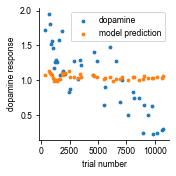

In [17]:
font = {'size': 8.5, 'family':'sans-serif', 'sans-serif':['Arial']}

matplotlib.rc('font', **font)
matplotlib.rcParams['pdf.fonttype'] = 42
fig, axs = plt.subplots(1,1, figsize=[2.5,2.5])
axs.scatter(rolling_mean_x, rolling_mean_APEs, s=8, label='dopamine')
axs.scatter(rolling_mean_x, rolling_mean_movement_pred, s=8, label='model prediction')
axs.set_xlabel('trial number')
axs.set_ylabel('dopamine response')
axs.legend(loc='best', frameon=True)
makes_plots_pretty(axs)
plt.tight_layout()


In [18]:
df = valid_contra_data.sort_values(by='actual trial numbers')
df = df.replace({'stay': 0, 'swiatch': 1, 'ipsi': 0, 'contra': 1})

mouse_data = df.dropna(axis=0)  
mouse_data['LogTrialN'] = np.log(mouse_data['actual trial numbers'])
Y = mouse_data['APE peaks'].reset_index(drop=True)
full_X = mouse_data[['average speed', 'abs fitted max cumsum ang vel', 'LogTrialN']].reset_index(drop=True)
full_X = sm.add_constant(full_X).reset_index(drop=True)
full_model = sm.OLS(Y, full_X)
full_result = full_model.fit()
full_model_rsq = full_result.rsquared
print(full_model_rsq)
full_model_prediction = full_model.predict(full_result.params)
full_model_diff_data = Y - full_model_prediction 

C:\Users\francescag\AppData\Local\Continuum\miniconda3\envs\py38\lib\site-packages\pandas\core\array_algos\replace.py:85: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  op = lambda x: operator.eq(x, b)


0.13728192410732076


C:\Users\francescag\AppData\Local\Temp\ipykernel_9696\3894201417.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mouse_data['LogTrialN'] = np.log(mouse_data['actual trial numbers'])


In [19]:
full_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              APE peaks   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     92.45
Date:                Thu, 14 Nov 2024   Prob (F-statistic):           1.60e-55
Time:                        14:21:47   Log-Likelihood:                -2338.8
No. Observations:                1747   AIC:                             4686.
Df Residuals:                    1743   BIC:                             4707.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             3.9903      0.266     14.998      0.000       3.468       4.512
average speed                    -0.0213      0.014     -1.561      0.119      -0.048       0.005
abs fitted max cumsum ang vel     0.0042      0.001      3.474      0.001       0.002       0.007
LogTrialN                        -0.3856      0.024    -15.931      0.000      -0.433      -0.338
==============================================================================
Omnibus:                       69.587   Durbin-Watson:                   1.720
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               77.005
Skew:                           0.506   Prob(JB):                     1.90e-17
Kurtosis:                       3.184   Cond. No.                     1.29e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.29e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
full_result.pvalues

const                            6.486276e-48
average speed                    1.188060e-01
abs fitted max cumsum ang vel    5.258263e-04
LogTrialN                        1.894586e-53
dtype: float64

In [21]:
mouse_data = df.dropna(axis=0)  
mouse_data['LogTrialN'] = np.log(mouse_data['actual trial numbers'])
residuals_X = mouse_data[['LogTrialN']].reset_index(drop=True)
residuals_X = sm.add_constant(residuals_X).reset_index(drop=True)
residuals_model = sm.OLS(movement_model_diff_data, residuals_X)
residuals_result = residuals_model.fit()
residuals_prediction = residuals_model.predict(residuals_result.params)
residuals_model_rsq = residuals_result.rsquared
print(residuals_model_rsq)

0.12478080696800242


C:\Users\francescag\AppData\Local\Temp\ipykernel_9696\2373863582.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mouse_data['LogTrialN'] = np.log(mouse_data['actual trial numbers'])


In [22]:
residuals_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              APE peaks   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     248.8
Date:                Thu, 14 Nov 2024   Prob (F-statistic):           1.69e-52
Time:                        14:21:48   Log-Likelihood:                -2341.1
No. Observations:                1747   AIC:                             4686.
Df Residuals:                    1745   BIC:                             4697.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0854      0.197     15.673      0.000       2.699       3.472
LogTrialN     -0.3786      0.024    -15.773      0.000      -0.426      -0.331
==============================================================================
Omnibus:                       74.022   Durbin-Watson:                   1.723
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.496
Skew:                           0.523   Prob(JB):                     1.22e-18
Kurtosis:                       3.195   Cond. No.                         74.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
data = mouse_data
valid_trial_numbers = data['actual trial numbers'].values
outcomes = data['outcome'].values
turn_angles = data['abs fitted max cumsum ang vel']
speeds = data['average speed']
window_size = 40
rolling_mean_x = []
rolling_mean_residuals = []
rolling_mean_model = []
rolling_mean_turn_angles = []
rolling_mean_speeds = []
num_bins = int(data.shape[0]/window_size)
for window_num in range(num_bins):
    rolling_mean_x.append(np.nanmean(valid_trial_numbers[window_num * window_size: (window_num + 1) * window_size]))
    rolling_mean_residuals.append(np.nanmean(movement_model_diff_data[window_num * window_size: (window_num + 1) * window_size]))
    rolling_mean_model.append(np.nanmean(residuals_prediction[window_num * window_size: (window_num + 1) * window_size]))
    rolling_mean_speeds.append(np.nanmean(speeds[window_num * window_size: (window_num + 1) * window_size]))
    rolling_mean_turn_angles.append(np.nanmean(turn_angles[window_num * window_size: (window_num + 1) * window_size]))

In [24]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '-')

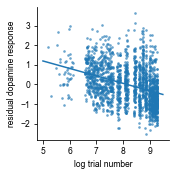

In [25]:
font = {'size': 8.5, 'family':'sans-serif', 'sans-serif':['Arial']}
slope = residuals_result.params['LogTrialN']
intercept = residuals_result.params['const']
matplotlib.rc('font', **font)
matplotlib.rcParams['pdf.fonttype'] = 42
fig, axs = plt.subplots(1,1, figsize=[2.5,2.5])
axs.scatter(residuals_X['LogTrialN'].values ,movement_model_diff_data , s=3, alpha=0.5)
abline(slope, intercept)
axs.set_xlabel('log trial number')
axs.set_ylabel('residual dopamine response')
makes_plots_pretty(axs)
plt.tight_layout()


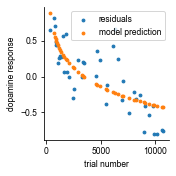

In [26]:

font = {'size': 8.5, 'family':'sans-serif', 'sans-serif':['Arial']}

matplotlib.rc('font', **font)
matplotlib.rcParams['pdf.fonttype'] = 42
fig, axs = plt.subplots(1,1, figsize=[2.5,2.5])
axs.scatter(rolling_mean_x, rolling_mean_residuals, s=8, label='residuals')
axs.scatter(rolling_mean_x, rolling_mean_model, s=8, label='model prediction')
axs.set_xlabel('trial number')
axs.set_ylabel('dopamine response')
axs.legend(loc='best', frameon=True)
makes_plots_pretty(axs)
plt.tight_layout()


In [27]:
residuals_result.params

const        3.085410
LogTrialN   -0.378557
dtype: float64

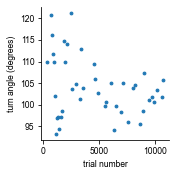

In [28]:

font = {'size': 8.5, 'family':'sans-serif', 'sans-serif':['Arial']}

matplotlib.rc('font', **font)
matplotlib.rcParams['pdf.fonttype'] = 42
fig, axs = plt.subplots(1,1, figsize=[2.5,2.5])
axs.scatter(rolling_mean_x, rolling_mean_turn_angles, s=8)

axs.set_xlabel('trial number')
axs.set_ylabel('turn angle (degrees)')
makes_plots_pretty(axs)

plt.tight_layout()


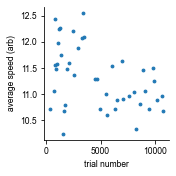

In [29]:
font = {'size': 8.5, 'family':'sans-serif', 'sans-serif':['Arial']}

matplotlib.rc('font', **font)
matplotlib.rcParams['pdf.fonttype'] = 42
fig, axs = plt.subplots(1,1, figsize=[2.5,2.5])
axs.scatter(rolling_mean_x, rolling_mean_speeds, s=8)

axs.set_xlabel('trial number')
axs.set_ylabel('average speed (arb)')
makes_plots_pretty(axs)

plt.tight_layout()


# For trial num without movement (as done in panel m)

In [30]:
def regression_with_and_without_trial_num(valid_contra_data):
    df = valid_contra_data.sort_values(by='actual trial numbers')
    mouse_data = df.dropna(axis=0)
    mouse_data['LogTrialN'] = np.log(mouse_data['actual trial numbers'])
    key4 = 'LogTrialN'
    Y = mouse_data['APE peaks'].reset_index(drop=True)
    X = mouse_data[[key4]].reset_index(drop=True)
    X = sm.add_constant(X).reset_index(drop=True)
    model = sm.OLS(Y, X)
    result = model.fit()
    trial_num_model_prediction = model.predict(result.params)
    trial_num_model_diff_data = Y - trial_num_model_prediction

    key = 'average speed'
    key1 = 'abs fitted max cumsum ang vel'
    mouse_data = df.dropna(axis=0)

    residuals_X = mouse_data[[key, key1]].reset_index(drop=True)
    residuals_X = sm.add_constant(residuals_X).reset_index(drop=True)
    residuals_model = sm.OLS(trial_num_model_diff_data, residuals_X)
    residuals_result = residuals_model.fit()
    residuals_pred = residuals_model.predict(residuals_result.params)
    speed_coef = residuals_result.params[key]
    turn_coef = residuals_result.params[key1]
    return speed_coef, turn_coef, trial_num_model_diff_data, trial_num_model_prediction, residuals_pred

In [31]:
speed_coef, turn_coef,  movement_model_diff_data, trial_num_model, residuals_pred = regression_with_and_without_trial_num(mouse_data)

In [32]:
data = mouse_data
valid_trial_numbers = data['actual trial numbers'].values
APEs = data['APE peaks'].values
outcomes = data['outcome'].values
window_size = 40
rolling_mean_x = []
rolling_mean_residuals = []
rolling_mean_trial_num = []
rolling_mean_APEs = []
rolling_mean_residuals_pred = []
num_bins = int(data.shape[0]/window_size)
for window_num in range(num_bins):
    rolling_mean_x.append(np.nanmean(valid_trial_numbers[window_num * window_size: (window_num + 1) * window_size]))
    rolling_mean_APEs.append(np.nanmean(APEs[window_num * window_size: (window_num + 1) * window_size]))
    rolling_mean_trial_num.append(np.nanmean(trial_num_model[window_num * window_size: (window_num + 1) * window_size]))
    rolling_mean_residuals.append(np.nanmean(movement_model_diff_data[window_num * window_size: (window_num + 1) * window_size]))
    rolling_mean_residuals_pred.append(np.nanmean(residuals_pred[window_num * window_size: (window_num + 1) * window_size]))

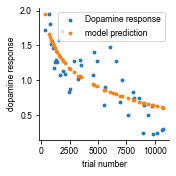

In [33]:

font = {'size': 8.5, 'family':'sans-serif', 'sans-serif':['Arial']}

matplotlib.rc('font', **font)
matplotlib.rcParams['pdf.fonttype'] = 42
fig, axs = plt.subplots(1,1, figsize=[2.5,2.5])
axs.scatter(rolling_mean_x, rolling_mean_APEs, s=8, label='Dopamine response')
axs.scatter(rolling_mean_x, rolling_mean_trial_num, s=8, label='model prediction')
axs.set_xlabel('trial number')
axs.set_ylabel('dopamine response')
axs.legend(loc='best', frameon=True)
makes_plots_pretty(axs)
plt.tight_layout()
plt.savefig(os.path.join(figure_directory, 'trial_num_model_no_movement.pdf'))

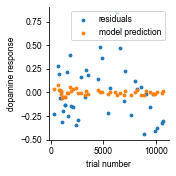

In [34]:
font = {'size': 8.5, 'family':'sans-serif', 'sans-serif':['Arial']}

matplotlib.rc('font', **font)
matplotlib.rcParams['pdf.fonttype'] = 42
fig, axs = plt.subplots(1,1, figsize=[2.5,2.5])
axs.scatter(rolling_mean_x, rolling_mean_residuals, s=8, label='residuals')
axs.scatter(rolling_mean_x, rolling_mean_residuals_pred, s=8, label='model prediction')
axs.set_xlabel('trial number')
axs.set_ylabel('dopamine response')
axs.legend(loc='best', frameon=True)
makes_plots_pretty(axs)
plt.tight_layout()
plt.savefig(os.path.join(figure_directory, 'trial_num_residuals_movement_prediction.pdf'))

# make stats plots


In [35]:
#load group data in
all_mice_df_save_dir = os.path.join(processed_data_path, 'turn_angle_over_time')

all_mice_df_save_file = os.path.join(all_mice_df_save_dir, 'movement_params_all_trials_vs_APE_regression_coefs_pvals_r2_and_trial_num_correlation_and_full_model.pkl')
all_mice_df = pd.read_pickle(all_mice_df_save_file)


In [36]:
all_mice_df['log trial number pval'] < 0.05

0    True
1    True
2    True
3    True
4    True
5    True
Name: log trial number pval, dtype: bool

In [37]:
trial_num_slope_df = all_mice_df[['mouse', 'log trial number']]
trial_num_slope_df['regressor'] = 'log trial number'

C:\Users\francescag\AppData\Local\Temp\ipykernel_9696\3251713814.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trial_num_slope_df['regressor'] = 'log trial number'


In [38]:
from scipy.stats import ttest_1samp

In [42]:
ttest_1samp(trial_num_slope_df['log trial number'], 0)


Ttest_1sampResult(statistic=-5.251139790341987, pvalue=0.003323093135816534)

In [43]:
cohen_d_one_sample(trial_num_slope_df['log trial number'])

cohen d:  -2.143768842393884


-2.143768842393884

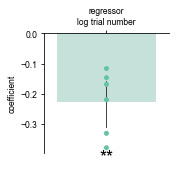

In [44]:
# fig sup 6L
font = {'size': 8.5, 'family':'sans-serif', 'sans-serif':['Arial']}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(1,1, figsize=[2.5,2.5])
matplotlib.rcParams['pdf.fonttype'] = 42


sns.barplot(data=trial_num_slope_df, x='regressor', y='log trial number', ax=ax, palette='Set2', errwidth=1, alpha=0.4)
sns.swarmplot(data=trial_num_slope_df, x='regressor', y='log trial number', ax=ax, palette='Set2')


ax.xaxis.tick_top()
ax.set_ylabel('coefficient')
ax.xaxis.set_label_position('top') 
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

y = trial_num_slope_df['log trial number'].to_numpy().min() - 0.05
ax.text(0, y, '**', ha='center', fontsize=18)

plt.tight_layout()


# first three sessions with pvals

In [45]:
#load group data in
all_mice_df_save_dir = os.path.join(processed_data_path, 'turn_angle_over_time')

all_mice_df_save_file = os.path.join(all_mice_df_save_dir, 'movement_params_first_3_sessions_vs_APE_regression_coefs_and_pvals.pkl')
all_mice_df_new = pd.read_pickle(all_mice_df_save_file)


In [46]:
all_mice_df = all_mice_df_new[all_mice_df_new['mouse'].isin(['SNL_photo16', 'SNL_photo17', 'SNL_photo18', 'SNL_photo21', 'SNL_photo22', 'SNL_photo26'])]

In [47]:
movement_param_df = all_mice_df
movement_param_df['sig turn angle'] = movement_param_df['turn angle pval']< 0.05
movement_param_df['sig speed'] = movement_param_df['speed pval']< 0.05


C:\Users\francescag\AppData\Local\Temp\ipykernel_9696\689196299.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movement_param_df['sig turn angle'] = movement_param_df['turn angle pval']< 0.05
C:\Users\francescag\AppData\Local\Temp\ipykernel_9696\689196299.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movement_param_df['sig speed'] = movement_param_df['speed pval']< 0.05


In [48]:
melted_movement_params = pd.melt(movement_param_df, id_vars=['mouse'], value_vars=['speed', 'turn angle'], value_name='coefficient', var_name='regressor')

In [49]:
significance = pd.concat([movement_param_df['speed pval']< 0.05, movement_param_df['turn angle pval']< 0.05], ignore_index=True)

In [50]:
melted_movement_params['sig'] = significance

In [51]:
sig_movement_params = melted_movement_params[melted_movement_params['sig']==True]
non_sig_movement_params = melted_movement_params[melted_movement_params['sig']==False]

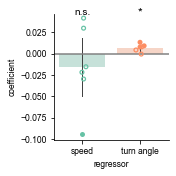

In [98]:
# fig sup 6E
font = {'size': 8.5, 'family':'sans-serif', 'sans-serif':['Arial']}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(1,1, figsize=[2.5,2.5])
matplotlib.rcParams['pdf.fonttype'] = 42


sns.barplot(data=melted_movement_params, x='regressor', y='coefficient', ax=ax, palette='Set2', errwidth=1, alpha=0.4)
sns.swarmplot(data=sig_movement_params,x='regressor', y='coefficient', ax=ax, palette='Set2', size=5)
sns.swarmplot(data=non_sig_movement_params,x='regressor', y='coefficient', ax=ax, palette='Set2', marker="$\circ$", ec="face", s=7.5)


# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
y = all_mice_df[['turn angle', 'speed']].to_numpy().max() + 0.005
h = .1
ax.text(0, y, 'n.s.', ha='center', fontsize=10)
ax.text(1, y, '*', ha='center', fontsize=12)
ax.axhline(0, color='gray')

plt.tight_layout()F


In [54]:
print(stats.ttest_1samp(all_mice_df['turn angle'], 0))
cohen_d_one_sample(all_mice_df['turn angle'])

Ttest_1sampResult(statistic=2.9286201368633993, pvalue=0.032685030540549345)
cohen d:  1.1956041642925275


1.1956041642925275

In [55]:
print(stats.ttest_1samp(all_mice_df['speed'], 0))
cohen_d_one_sample(all_mice_df['speed'])

Ttest_1sampResult(statistic=-0.8220212146670713, pvalue=0.448474594800367)
cohen d:  -0.33558875561286006


-0.33558875561286006

# r-squared

In [99]:
#load group data in
all_mice_df_save_dir = os.path.join(processed_data_path, 'turn_angle_over_time')

all_mice_df_save_file = os.path.join(all_mice_df_save_dir, 'movement_params_all_trials_vs_APE_regression_coefs_pvals_r2_and_trial_num_correlation_and_full_model.pkl')
all_mice_df = pd.read_pickle(all_mice_df_save_file)


In [100]:
exp_var_df = all_mice_df[['mouse', 'speed r2', 'turn angle r2', 'log trial number r2', 'full model']]

In [101]:
exp_var_df = exp_var_df.rename(columns={'speed r2': 'speed', 'turn angle r2': 'turn angle', 'log trial number r2': 'log trial number',})

In [102]:
melted_df = pd.melt(exp_var_df, id_vars=['mouse'], value_vars=['speed', 'turn angle', 'log trial number', 'full model'], value_name='% of explained variance', var_name='regressor')

In [103]:
def make_box_plot(df, fig_ax,  dx ='regressor', dy = '% of explained variance', ort = "v", pal = ['#E95F32', '#002F3A', '#F933FF' ], set_ylims=False, label=None, scatter_size=4):
    custom_palette = sns.set_palette(sns.color_palette(pal))
    speed_data = df[df.regressor == 'speed']
    speed_noise = np.random.normal(0, 0.04, speed_data.shape[0])
    turn_angle_data = df[df.regressor == 'turn angle']
    turn_angle_noise = np.random.normal(0, 0.04, turn_angle_data.shape[0])
    trial_num_data = df[df.regressor == 'log trial number']
    trial_num_noise = np.random.normal(0, 0.04, trial_num_data.shape[0])
    fig_ax.scatter((speed_data[dx].values == 'speed').astype(int) * 0 + speed_noise - 0.3, speed_data[dy].values, color=pal[0], s=7, alpha=0.6)
    fig_ax.scatter((turn_angle_data[dx].values == 'turn angle').astype(int) + turn_angle_noise - 0.3, turn_angle_data[dy].values, color=pal[1],
                   s=7, alpha=0.6)
    fig_ax.scatter((trial_num_data[dx].values == 'log trial number').astype(int)*2 + trial_num_noise - 0.3, trial_num_data[dy].values, color=pal[2],
                   s=7, alpha=0.6)
    
    sns.boxplot(x=dx, y=dy, data=df, palette=custom_palette, width = .3, zorder = 10,linewidth=0.1, \
                showcaps = True, boxprops = {"zorder":10, 'alpha':.9},\
                showfliers=False, whiskerprops = {'linewidth':0.5, "zorder":10},\
                   saturation = 1, orient = ort, ax=fig_ax,
                 medianprops={'color':'white', 'linewidth':1})
    #fig_ax.set_xlim([-1, 3])
    if set_ylims:
        fig_ax.set_ylim([-2, np.max(df[dy]) + 2]) 
    if label:
        fig_ax.text(0.5, 1, label, transform=fig_ax.get_xaxis_transform(), size=8, ha='center')

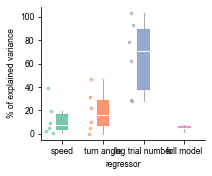

In [104]:
# fig sup 6M
font = {'size': 8.5, 'family':'sans-serif', 'sans-serif':['Arial']}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(1,1, figsize=[3,2.5])
matplotlib.rcParams['pdf.fonttype'] = 42
pal = sns.color_palette('Set2')
pal.as_hex()[:3]
make_box_plot(melted_df, ax, pal=pal)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.tight_layout()


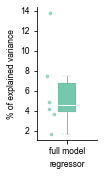

In [25]:
font = {'size': 8.5, 'family':'sans-serif', 'sans-serif':['Arial']}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(1,1, figsize=[1.5,2.5])
matplotlib.rcParams['pdf.fonttype'] = 42
pal = sns.color_palette('Set2')
pal.as_hex()[:3]
dx ='regressor'
dy = '% of explained variance'
ort='v'
custom_palette = sns.set_palette(sns.color_palette(pal))
full_data = melted_df[melted_df.regressor == 'full model']
full_noise = np.random.normal(0, 0.04, full_data.shape[0])

ax.scatter((full_data[dx].values == 'full model').astype(int) * 0 + full_noise - 0.3, full_data[dy].values, color=pal[0], s=7, alpha=0.6)

sns.boxplot(x=dx, y=dy, data=full_data, palette=custom_palette, width = .3, zorder = 10,linewidth=0.1, \
            showcaps = True, boxprops = {"zorder":10, 'alpha':.9},\
            showfliers=False, whiskerprops = {'linewidth':0.5, "zorder":10},\
               saturation = 1, orient = ort, ax=ax,
             medianprops={'color':'white', 'linewidth':1})
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.tight_layout()


In [28]:
full_data['% of explained variance'].mean()

5.946208154409445

In [27]:
melted_df[melted_df.regressor == 'speed']['% of explained variance'].median()

7.2471469277796885

In [29]:
melted_df[melted_df.regressor == 'turn angle']['% of explained variance'].median()

15.855575858789553

In [30]:
melted_df[melted_df.regressor == 'log trial number']['% of explained variance'].median()

70.4037371713486

# trial number movement regressions

In [66]:
#load group data in
all_mice_df_save_dir = os.path.join(processed_data_path, 'turn_angle_over_time')

all_mice_df_save_file = os.path.join(all_mice_df_save_dir, 'movement_params_all_trials_vs_APE_regression_coefs_pvals_r2_and_trial_num_correlation_and_full_model.pkl')
all_mice_df = pd.read_pickle(all_mice_df_save_file)


In [67]:
movement_param_df = all_mice_df
movement_param_df['sig turn angle'] = movement_param_df['trial_num_turn_pval']< 0.05
movement_param_df['sig speed'] = movement_param_df['trial_num_speed_pval']< 0.05


In [68]:
melted_movement_params = pd.melt(movement_param_df, id_vars=['mouse'], value_vars=['trial_num_slope_speed','trial_num_slope_turn_ang'], value_name='coefficient', var_name='regressor')

In [69]:
significance = pd.concat([movement_param_df['speed pval']< 0.05, movement_param_df['turn angle pval']< 0.05], ignore_index=True)

In [70]:
melted_movement_params['sig'] = significance

In [71]:
sig_movement_params = melted_movement_params[melted_movement_params['sig']==True]
non_sig_movement_params = melted_movement_params[melted_movement_params['sig']==False]

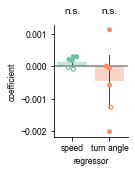

In [72]:
# fig sup 6H
font = {'size': 8.5, 'family':'sans-serif', 'sans-serif':['Arial']}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(1,1, figsize=[2,2.5])
matplotlib.rcParams['pdf.fonttype'] = 42


sns.barplot(data=melted_movement_params, x='regressor', y='coefficient', ax=ax, palette='Set2', errwidth=1, alpha=0.4)
sns.swarmplot(data=sig_movement_params,x='regressor', y='coefficient', ax=ax, palette='Set2', size=5)
sns.swarmplot(data=non_sig_movement_params,x='regressor', y='coefficient', ax=ax, palette='Set2', marker="$\circ$", ec="face", s=7.5)


# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
y = all_mice_df[['trial_num_slope_speed','trial_num_slope_turn_ang']].to_numpy().max() + 0.0005
h = .1
ax.text(0, y, 'n.s.', ha='center', fontsize=10)
ax.text(1, y, 'n.s.', ha='center', fontsize=10)
ax.set_xticklabels(['speed', 'turn angle'])
ax.axhline(0, color='gray')

plt.tight_layout()


In [73]:
ttest_1samp(all_mice_df['trial_num_slope_turn_ang'], 0)

Ttest_1sampResult(statistic=-1.054810014595123, pvalue=0.3397918062476374)

In [74]:
ttest_1samp(all_mice_df['trial_num_slope_speed'], 0)

Ttest_1sampResult(statistic=1.6771028889657587, pvalue=0.15436692036149124)

In [75]:
cohen_d_one_sample(all_mice_df['trial_num_slope_turn_ang'])

cohen d:  -0.43062438522262136


-0.43062438522262136

In [77]:
cohen_d_one_sample(all_mice_df['trial_num_slope_speed'])

cohen d:  0.6846743873522768


0.6846743873522768